# BULLDOZER SALE PRICE PREDICTION🚜

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

**1.Problem defition**
> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

**2.Data**
The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:
* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

**3.Evaluation**

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

**4.Features**
Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [1]:
import numpy as np
import pandas as pd
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [5]:
# Import training and validation sets
df_back_up = pd.read_csv(r"D:\DataBases\DataSets\MrdBourke\bluebook-for-bulldozers/TrainAndValid.csv",
                 low_memory=True)
data = df_back_up.copy()
df_shape = (data.shape)
print(f"There are {df_shape[0]} rows and {df_shape[1]} columns in the dataset")
print(f"Data timeperiod covers: {min(data.index)} to {max(data.index)}")

There are 412698 rows and 53 columns in the dataset
Data timeperiod covers: 0 to 412697


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [11]:
data.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 1.EDA

In [12]:
data.isnull().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

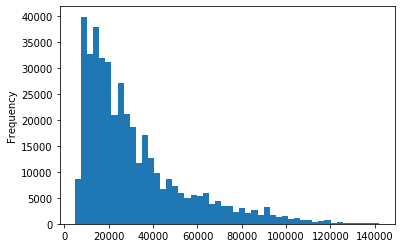

In [7]:
jàn çlo

**IMPORT DATA WITH PARSE DATES**

In [19]:
%%time
# Import data again but this time parse dates
df_back_up = pd.read_csv(r"D:\DataBases\DataSets\MrdBourke\bluebook-for-bulldozers/TrainAndValid.csv",
                 low_memory=True,
                 parse_dates=["saledate"])

data = df_back_up.copy()
df_shape = (data.shape)
print(f"There are {df_shape[0]} rows and {df_shape[1]} columns in the dataset")
print(f"Data timeperiod covers: {min(data.index)} to {max(data.index)}")

There are 412698 rows and 53 columns in the dataset
Data timeperiod covers: 0 to 412697
Wall time: 3.83 s


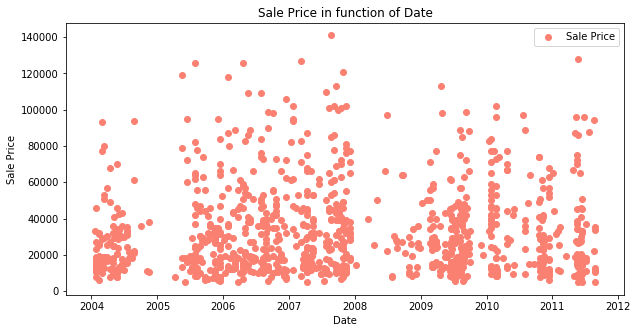

In [27]:
plt.figure(figsize=(10, 5))

plt.scatter(data["saledate"][:1000], data["SalePrice"][:1000],color= "salmon")

plt.title("Sale Price in function of Date")
plt.xlabel("Date")
plt.ylabel("Sale Price")
plt.legend(["Sale Price"]);

**SORT DATA FRAME BY DATE**

In [29]:
data.saledate.head()

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

In [30]:
data.sort_values(by=["saledate"], inplace=True, ascending=True)

In [31]:
data.saledate.head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [34]:
#Make a copy of the original df
data_temp = data.copy()

**ADD DATETIME PARAMETERS FOR `saledate` COLUMN**

In [35]:
#To create new features namely SaleYear, SaleMonth, SaleDay,SaleDayOfWeek, SaleDayOfYear using the variable Sale date  
data_temp["SaleYear"] = data_temp.saledate.dt.year
data_temp["SaleMonth"] = data_temp.saledate.dt.month
data_temp["SaleDay"] = data_temp.saledate.dt.day
data_temp["SaleDayOfWeek"] = data_temp.saledate.dt.dayofweek
data_temp["SaleDayOfYear"] = data_temp.saledate.dt.dayofyear

In [37]:
data_temp.head(2)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,SaleYear,SaleMonth,SaleDay,SaleDayOfWeek,SaleDayOfYear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,TD20,TD20,NaN,NaN,NaN,Medium,"Track Type Tractor, Dozer - 105.0 to 130.0 Hor...",Texas,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Direct Drive,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,A66,A66,NaN,NaN,NaN,NaN,Wheel Loader - 120.0 to 135.0 Horsepower,Florida,WL,Wheel Loader,NaN,OROPS,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31


In [38]:
#Drop original saledate column
data_temp.drop("saledate", axis=1, inplace=True)

In [39]:
data_temp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

# 2.DATA PREPROCESSING

In [52]:
pd.api.types.is_string_dtype(data_temp["UsageBand"])

True

In [54]:
#Find the column that contains string
for label, content in data_temp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


**CREATING CATEGORICAL VARIABLES**

In [56]:
#To convert all the string values into category values
for label, content in data_temp.items():
    if pd.api.types.is_string_dtype(content):
        data_temp[label] = content.astype("category").cat.as_ordered()

In [57]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [62]:
print(data_temp.isnull().sum()/len(data_temp))

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

In [63]:
#To export data
data_temp.to_csv(r"D:/DataBases/DataSets/MrdBourke/bluebook-for-bulldozers/train_temp.csv", 
                 index=False)

**FILL NUMERIC MISSING VALUES**

In [65]:
#To convert all the string values into category values
for label, content in data_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
SaleYear
SaleMonth
SaleDay
SaleDayOfWeek
SaleDayOfYear


In [66]:
#Check which numeric comumns has missing values
for label, content in data_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [67]:
#Fill missing numeric row with the column median
for label, content in data_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            #add a binary column to tell whether the data was missing or not
            data_temp[label + "_is_missing"] = pd.isnull(content)
            #Fill missing with median
            data_temp[label] = content.fillna(content.median())                                             

In [68]:
#To check if there is still some missing values
for label, content in data_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [69]:
data_temp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [70]:
data_temp.isnull().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

In [71]:
#To check for columns that aren't numerics
for label, content in data_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
            print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [73]:
pd.Categorical(data_temp["state"]).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [74]:
#codes assign -1 to all missing values
pd.Categorical(data_temp["UsageBand"]).codes

array([-1, -1, -1, ..., -1, -1, -1], dtype=int8)

In [75]:
#We add +1 to all missing values to turn them into 0
pd.Categorical(data_temp["UsageBand"]).codes + 1

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [76]:
#Turn categorical into numbers and fill missing
for label, content in data_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        #add a binary column to tell whether the data was missing or not(True=1(missing), False=0(not_missing))
            data_temp[label + "_is_missing"] = pd.isnull(content)
            #Turn categories into numbers and add +1
            data_temp[label] = pd.Categorical(content).codes + 1           

In [95]:
data_temp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,SaleYear,SaleMonth,SaleDay,SaleDayOfWeek,SaleDayOfYear,auctioneerID_is_missing,MachineHoursCurrentMeter_is_missing,UsageBand_is_missing,fiModelDesc_is_missing,fiBaseModel_is_missing,fiSecondaryDesc_is_missing,fiModelSeries_is_missing,fiModelDescriptor_is_missing,ProductSize_is_missing,fiProductClassDesc_is_missing,state_is_missing,ProductGroup_is_missing,ProductGroupDesc_is_missing,Drive_System_is_missing,Enclosure_is_missing,Forks_is_missing,Pad_Type_is_missing,Ride_Control_is_missing,Stick_is_missing,Transmission_is_missing,Turbocharged_is_missing,Blade_Extension_is_missing,Blade_Width_is_missing,Enclosure_Type_is_missing,Engine_Horsepower_is_missing,Hydraulics_is_missing,Pushblock_is_missing,Ripper_is_missing,Scarifier_is_missing,Tip_Control_is_missing,Tire_Size_is_missing,Coupler_is_missing,Coupler_System_is_missing,Grouser_Tracks_is_missing,Hydraulics_Flow_is_missing,Track_Type_is_missing,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,1744,0,0,0,4,47,44,5,5,0,6,0,0,0,0,3,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,6,0,0,1989,1,17,1,17,False,True,True,False,False,True,True,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
274835,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,559,0,0,0,0,60,9,6,6,0,6,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,1989,1,31,1,31,False,True,True,False,False,True,True,True,True,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
141296,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,713,59,0,0,2,50,9,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,6,0,0,1989,1,31,1,31,False,True,True,False,False,False,True,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
212552,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,558,0,0,0,0,74,9,6,6,0,1,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,1989,1,31,1,31,False,True,True,False,False,True,True,True,True,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
62755,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,683,21,0,0,0,51,9,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,5,0,0,1989,1,31,1,31,False,True,True,False,False,False,True,True,True,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True


In [94]:
data_temp.isnull().sum().sum()

0

In [96]:
#To export validation data as csv file
data_temp.to_csv(r"D:/DataBases/DataSets/MrdBourke/bluebook-for-bulldozers/train_val_preprocessed.csv", 
                 index=False)

In [8]:
#To import validation data
data_temp_back_up = pd.read_csv(r"D:/DataBases/DataSets/MrdBourke/bluebook-for-bulldozers/train_val_preprocessed.csv", 
                          low_memory=True)

data_temp = data_temp_back_up.copy()
df_shape = (data_temp.shape)
print(f"There are {df_shape[0]} rows and {df_shape[1]} columns in the dataset")
print(f"Data timeperiod covers: {min(data_temp.index)} to {max(data_temp.index)}")

There are 412698 rows and 103 columns in the dataset
Data timeperiod covers: 0 to 412697


# 3.MODEL BUILDING

**FIT AND EVALUATING WITH THE SAME DATA SET**

In [83]:
%%time
#instantiate the model
model = RandomForestRegressor(random_state = 88)
#fit the model
model.fit(data_temp.drop("SalePrice", axis=1), data_temp["SalePrice"])

Wall time: 13min 21s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=88, verbose=0, warm_start=False)

In [84]:
%%time
model.score(data_temp.drop("SalePrice", axis=1), data_temp["SalePrice"])

Wall time: 18.7 s


0.9876002703205153

**SPLITTING THE DATA INTO TRAIN/VALIDATION SETS**

In [9]:
data_temp.SaleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: SaleYear, dtype: int64

In [10]:
#All sample with a SaleYear  equal to 2012 should be in the validation set
#and all sample which don't have a SaleYear 2012 should be in the training set 
data_val = data_temp[data_temp.SaleYear == 2012]
data_train = data_temp[data_temp.SaleYear != 2012]
len(data_val), len(data_train) 

(11573, 401125)

In [11]:
#To split the data into train and validation sets
X_train, y_train = data_train.drop("SalePrice", axis=1), data_train.SalePrice
X_val, y_val = data_val.drop("SalePrice", axis=1), data_val.SalePrice

print("The shape of the inputs train set is", X_train.shape)
print("The shape of the targets train set is", y_train.shape)
print("The shape of the inputs validation set is", X_val.shape)
print("The shape of the targets validation set is", y_val.shape)

The shape of the inputs train set is (401125, 102)
The shape of the targets train set is (401125,)
The shape of the inputs validation set is (11573, 102)
The shape of the targets validation set is (11573,)


**BUILDING AN EVALUATION FUNCTION**

In [12]:
#The principal evaluation metric will be the RMSE(Root Squared Mean Error(F-1 score)) 
#mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error

def rmsle(y_test, y_pred):
    """
    calculate rsmle between predictions and true labels  
    """
    return np.sqrt(mean_squared_log_error(y_test, y_pred))

def show_scores(model):
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    scores = {"Training MAE": mean_absolute_error(y_train, train_pred), 
              "Valid MAE": mean_absolute_error(y_val, val_pred),
              "Training RMSLE": rmsle(y_train, train_pred),
              "Test RMSLE": rmsle(y_val, val_pred),
              "Training R^2": r2_score(y_train, train_pred),
              "Test R^2": r2_score(y_val, val_pred)}
    return(scores)

**TESTING THE MODEL ON SUBSET TO TUNE HYPERPARAMETERS**

In [97]:
%%time
#instantiate the model
model = RandomForestRegressor(random_state = 88, max_samples=10000, n_estimators=100)
#fit the model
model.fit(X_train, y_train)

Wall time: 30.6 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=10000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=88, verbose=0, warm_start=False)

In [98]:
show_scores(model)

{'Training MAE': 5549.691534658773,
 'Valid MAE': 7137.001892335609,
 'Training RMSLE': 0.25717614025899616,
 'Test RMSLE': 0.29228240015084433,
 'Training R^2': 0.8610337976387878,
 'Test R^2': 0.8341570219631544}

**RANDOMIZEDSEARCHCV**

In [16]:
#serching optimal turning parameters using RandomizedSearchCv
%%time
grid={"n_estimators":np.arange(10,100, 10),
      "max_depth":[None, 3, 5, 10],
      "max_features":[0.5, 1, "sqrt", "auto"],
      "min_samples_split":np.arange(1, 20, 2),
      "min_samples_leaf":np.arange(1, 20, 2),
      "max_samples":[10000]}

#Instantiate the model
rf = RandomForestRegressor(random_state = 88)
#rsCV
rscv_rf = RandomizedSearchCV(estimator=rf,
                             param_distributions=grid,
                             n_iter=5,#number of model to try
                             cv=5,
                             verbose=True)
#fit the RandomizedSearchCv
rscv_rf.fit(X_train, y_train)
#We evaluate the prediction
rscv_rf_metrics = show_scores(rscv_rf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.8min finished


Wall time: 4min 8s


In [17]:
#call the estimator with the best result 
rscv_rf.best_params_

{'n_estimators': 60,
 'min_samples_split': 7,
 'min_samples_leaf': 13,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': None}

In [18]:
rscv_rf_metrics

{'Training MAE': 6274.598267417283,
 'Valid MAE': 7836.58719619236,
 'Training RMSLE': 0.2836498898939148,
 'Test RMSLE': 0.3136940598012928,
 'Training R^2': 0.821353634882988,
 'Test R^2': 0.7916637948570524}

**MODEL WITH THE BEST HYPERTURNING PARAMETERS**

In [13]:
%%time
#instantiate the model with the best hyper parameters
tuned_rf = RandomForestRegressor(random_state = 88, n_estimators = 40, min_samples_leaf = 1, 
                                 min_samples_split =14, max_samples=None, max_features =0.5)

#Fit
tuned_rf.fit(X_train, y_train)

Wall time: 2min 27s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=14, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=None, oob_score=False,
                      random_state=88, verbose=0, warm_start=False)

**COMPARING METRICS**

In [14]:
#Scores for tuned model (ideal model) trained on all sample
tuned_rf_metrics = show_scores(tuned_rf)
tuned_rf_metrics

{'Training MAE': 2957.4690588214794,
 'Valid MAE': 5979.240458972128,
 'Training RMSLE': 0.1445876065815493,
 'Test RMSLE': 0.24717201174059497,
 'Training R^2': 0.9587811736724959,
 'Test R^2': 0.8806282802940707}

In [19]:
#scores of RandomizedSearchCv Model only trained on ~10000 examples
rscv_rf_metrics

{'Training MAE': 6274.598267417283,
 'Valid MAE': 7836.58719619236,
 'Training RMSLE': 0.2836498898939148,
 'Test RMSLE': 0.3136940598012928,
 'Training R^2': 0.821353634882988,
 'Test R^2': 0.7916637948570524}

.Withe the optimal turning parameter we see an improvement of the RMSLE of the validation data set from 0.31 to 0.24 

In [21]:
#2 Method to save a trained ML model
import pickle
model = tuned_rf
filename = r"D:/DataBases/DataSets/MrdBourke/bluebook-for-bulldozers/tuned_rf_SalePrice_Predictions.sav"
pickle.dump(model, open(filename, 'wb'))

In [ ]:
#To load the saved Model
filename = r"D:/DataBases/DataSets/MrdBourke/bluebook-for-bulldozers/tuned_rf_SalePrice_Predictions.sav"
tuned_rf = pickle.load(open(filename, 'rb'))

# 4. USED IDEAL MODEL TO MAKE PREDICTION ON TEST DATA SET

In [69]:
test_data_back_up = pd.read_csv(r"D:/DataBases/DataSets/MrdBourke/bluebook-for-bulldozers/Test.csv", 
                          low_memory=True, parse_dates=["saledate"])

test_data = test_data_back_up.copy()
df_shape = (test_data.shape)
print(f"There are {df_shape[0]} rows and {df_shape[1]} columns in the dataset")
print(f"Data timeperiod covers: {min(test_data.index)} to {max(test_data.index)}")

There are 12457 rows and 52 columns in the dataset
Data timeperiod covers: 0 to 12456


In [70]:
test_data.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,580,G,NaN,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,Wyoming,BL,Backhoe Loaders,Two Wheel Drive,OROPS,Yes,None or Unspecified,No,Standard,Standard,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,936,NaN,NaN,NaN,Medium,Wheel Loader - 135.0 to 150.0 Horsepower,Virginia,WL,Wheel Loader,NaN,EROPS,Yes,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,20.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,EC210,B,NaN,LC,Large / Medium,"Hydraulic Excavator, Track - 21.0 to 24.0 Metr...",New Jersey,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,330,C,NaN,L,Large / Medium,"Hydraulic Excavator, Track - 33.0 to 40.0 Metr...",New Jersey,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,650,K,NaN,NaN,NaN,"Track Type Tractor, Dozer - 20.0 to 75.0 Horse...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Hydrostatic,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


**PREPROCESS THE TEST DATA SET(GET THE TEST DATA IN THE SAME FORMAT AS THE TRAINING SET)**

In [71]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    df["SaleYear"] = df.saledate.dt.year
    df["SaleMonth"] = df.saledate.dt.month
    df["SaleDay"] = df.saledate.dt.day
    df["SaleDayOfWeek"] = df.saledate.dt.dayofweek
    df["SaleDayOfYear"] = df.saledate.dt.dayofyear
    
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing or not
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
    
        # Filled categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add +1 to the category code because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1
    
    return df

In [72]:
test_data_prep = preprocess_data(test_data)
test_data_prep.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,SaleYear,SaleMonth,SaleDay,SaleDayOfWeek,SaleDayOfYear,MachineHoursCurrentMeter_is_missing,UsageBand_is_missing,fiModelDesc_is_missing,fiBaseModel_is_missing,fiSecondaryDesc_is_missing,fiModelSeries_is_missing,fiModelDescriptor_is_missing,ProductSize_is_missing,fiProductClassDesc_is_missing,state_is_missing,ProductGroup_is_missing,ProductGroupDesc_is_missing,Drive_System_is_missing,Enclosure_is_missing,Forks_is_missing,Pad_Type_is_missing,Ride_Control_is_missing,Stick_is_missing,Transmission_is_missing,Turbocharged_is_missing,Blade_Extension_is_missing,Blade_Width_is_missing,Enclosure_Type_is_missing,Engine_Horsepower_is_missing,Hydraulics_is_missing,Pushblock_is_missing,Ripper_is_missing,Scarifier_is_missing,Tip_Control_is_missing,Tire_Size_is_missing,Coupler_is_missing,Coupler_System_is_missing,Grouser_Tracks_is_missing,Hydraulics_Flow_is_missing,Track_Type_is_missing,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,25,0,0,0,2,51,1,1,4,3,2,2,1,2,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2012,5,3,3,124,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,0,0,0,4,57,46,6,6,0,1,2,0,2,0,0,0,0,0,0,0,1,0,0,0,0,7,3,0,0,0,0,0,0,0,0,0,0,0,0,3,2,2012,5,10,3,131,False,False,False,False,True,True,True,False,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,9,0,33,3,14,29,4,4,0,2,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,2,17,17,2,1,1,0,0,0,0,0,2012,5,10,3,131,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,13,0,32,3,18,29,4,4,0,2,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,3,0,0,0,2,17,20,2,2,2,0,0,0,0,0,2012,5,10,3,131,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,33,0,0,0,48,8,5,5,0,3,0,0,0,0,3,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,5,0,0,2012,5,10,3,131,False,False,False,False,False,True,True,True,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True


In [73]:
#To find out how the columns of two data set differ
set(X_train.columns) - set(test_data_prep.columns)

{'auctioneerID_is_missing'}

In [74]:
test_data_prep.shape

(12457, 101)

In [75]:
#`auctioneerID_is_missing` column is missing in the test data set. We have to manually adjust to have `auctioneerID_is_missing` in the test set to match the same dimension as th etraining data set
test_data_prep["auctioneerID_is_missing"] = False
test_data_prep.shape

(12457, 102)

**MAKE PREDICTION ON THE TEST DATA**

In [76]:
# Make predictions on updated test data
test_pred = tuned_rf.predict(test_data_prep)

In [77]:
test_pred

array([20423.41691698, 20203.13762222, 53533.47610105, ...,
       14719.02871524, 17163.98472412, 25978.53357337])

In [78]:
#Format price prediction into dataframe format
price_pred = pd.DataFrame()
price_pred["SalesID"] = test_data_prep["SalesID"]
price_pred["SalesPrice"] = test_pred
price_pred.head()

,SalesID,SalesPrice
0,1227829,20423.416917
1,1227844,20203.137622
2,1227847,53533.476101
3,1227848,57912.067076
4,1227863,40292.931987


**FEATURES IMPORTANCE**

.Seek to figure out which different attributes of the date were most important when it comes to prediction the target bariable `SalePrice` 

In [81]:
#Find feature importance off the RandomForestRegressor
tuned_rf.feature_importances_ 

array([3.50845229e-02, 1.97380518e-02, 3.90418236e-02, 1.60974533e-03,
       3.31205880e-03, 2.08076728e-01, 3.20435511e-03, 9.91754276e-04,
       3.88429829e-02, 5.87810333e-02, 6.01069060e-02, 4.72425869e-03,
       1.37847830e-02, 1.54809713e-01, 3.79672370e-02, 5.91726389e-03,
       3.67381350e-03, 2.86203394e-03, 3.93785975e-03, 6.53430865e-02,
       3.78594607e-04, 4.64688295e-05, 1.06350023e-03, 2.07163351e-04,
       2.13370976e-03, 2.14348490e-05, 1.07827077e-04, 8.63379538e-03,
       6.07822212e-03, 2.80363622e-04, 2.54021054e-03, 4.40329491e-03,
       3.93999403e-03, 1.46752045e-03, 2.82621023e-04, 5.27910513e-03,
       8.59517962e-04, 1.11959023e-02, 1.52129371e-03, 1.36467515e-03,
       7.65109585e-04, 9.51862300e-04, 1.45759381e-03, 5.67454348e-04,
       5.36521323e-04, 3.71306620e-04, 2.17591052e-04, 2.44964745e-03,
       1.06031022e-03, 3.29620549e-04, 2.28801719e-04, 7.22492749e-02,
       3.81392163e-03, 5.70853610e-03, 2.91361111e-03, 9.83156719e-03,
      

In [96]:
def plot_features(columns, importances, n=20): #To get the 20 best parameters
    df = (pd.DataFrame({"Features":columns, 
                       "Features_Importances":importances})
         .sort_values("Features_Importances", ascending=False)
         .reset_index(drop=True))
    #plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(df["Features"][:n], df["Features_Importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Features Importance")
    ax.invert_yaxis()

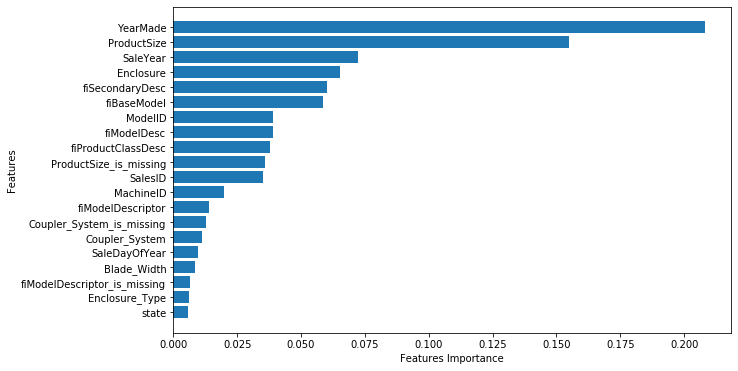

In [97]:
plot_features(X_train.columns, tuned_rf.feature_importances_)

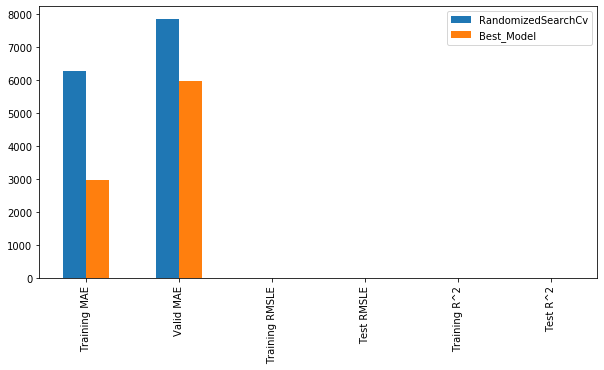

In [79]:
#Compare the models
all_metrics = pd.DataFrame({"RandomizedSearchCv":rscv_rf_metrics,
                           "Best_Model":tuned_rf_metrics})
all_metrics.plot.bar(figsize=(10, 5));